In [2]:
import sympy
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from sympy.functions.special.polynomials import chebyshevt
from scipy.optimize import minimize
from pyqsp import sym_qsp_opt

In [3]:
try:
    # Input
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # Define the symbols
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # Parse the Function String
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # VALIDATE
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")






Entered definite integral Mathematical expression:


10          
⌠           
⎮  log(x) dx
⌡           
1           

In [4]:
def getChebyshevPolynomial( sympy_symbol,sympy_func ,degree, lower_limit, upper_limit):
    """
    Generates a high-quality Chebyshev polynomial approximation for a given SymPy function
    using NumPy's fitting method.
    This is the ideal method because Taylor's approximation requires O(d^2) oracle calls.
    Chebyshev approximation also uniformly distributes the error in the range making it ideal for this scenario.
    """
    print(f"Chebyshev Approximation to {degree}th degree:\n")

    # 1. Callable numerical version of the function "Oracle"
    f_numeric = sympy.lambdify(sympy_symbol, sympy_func, 'numpy')

    # 2. Define the coordinate transformation from [lower_limit, upper_limit] to [-1, 1]
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This is f(x) re-parameterized in terms of y. This is the function we will approximate.
    func_to_approximate = lambda y_val: f_numeric(jac_scaling * y_val + offset)

    # 3. Generate sample points and query the oracle to get data for fitting
    # For a degree `d` polynomial, we need at least `d+1` points. 2*degree is ideal
    num_samples = 2 * degree
    sample_points_y = np.linspace(-1, 1, num_samples)
    sample_values_f = func_to_approximate(sample_points_y)

    # 4. Use NumPy to fit the Chebyshev polynomial to the sampled data
    cheb_poly_fit = np.polynomial.chebyshev.Chebyshev.fit(
        sample_points_y,
        sample_values_f,
        deg=degree
    )
    
    # The coefficients are ordered from T_0 to T_d
    coeffs = cheb_poly_fit.convert().coef
    print(f"Found {len(coeffs)} coefficients.")

    # 5. Calculate the scaling factor M = 4 * max(|f(x)|)
    # We find the max value by evaluating our new high-quality approximation on a fine grid.
    fine_grid_y = np.linspace(-1, 1, 1000)
    max_f_val = np.max(np.abs(cheb_poly_fit(fine_grid_y)))
    M = 4.0 * max_f_val
    print(f"M value for scaling is: {M:.4f}")

    # 6. Reconstruct a SymPy expression for display and symbolic integration
    # The polynomial for the integral must approximate g(y) = f(x) * jac_scaling
    y_sym = sympy.Symbol('y')
    chebyshev_sympy_f = sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))
    chebyshev_sympy_g = jac_scaling * chebyshev_sympy_f

    integration_expr = sympy.Integral(chebyshev_sympy_g, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)
    
    # 7. New: Explicitly check the endpoint error to verify the quality
    true_val_at_endpoint = func_to_approximate(1.0) # This is f(upper_limit)
    approx_val_at_endpoint = cheb_poly_fit(1.0)
    abs_error = np.abs(true_val_at_endpoint - approx_val_at_endpoint)
    
    print(f"\nError analysis at endpoint y=1 (x={upper_limit}):")
    print(f"  - True value of f({upper_limit}) = {true_val_at_endpoint:.8f}")
    print(f"  - Approx value from poly = {approx_val_at_endpoint:.8f}")
    print(f"  - Absolute Error = {abs_error:.2e}")

    return coeffs, M, chebyshev_sympy_g

In [5]:
# Discretize func_expr
def discretize(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [6]:
# Degree of Approximation
d= 12
num_qubits=14
N=2**num_qubits

In [7]:
# Plot an unscaled approximated polyomial to show that the approximated graph is very close to the original.
# Also Plot the |f(x)-P(x)| graph to show that the error is uniformly distributed.
### NOTE: Here g(y) is returned. g(y)= f(x)* jac_scaling.  f(x)= g(y)/jac_scaling..
#  jac_scaling=(upper-lower)/2
chebyshev_coeffs, M,chebyshev_Polynomial= getChebyshevPolynomial(x,func, d, lower_limit, upper_limit)
#The coefffs returned here are unscaled coeffs. Coeffs to load= chebyshev_coeffs/M

Chebyshev Approximation to 12th degree:

Found 13 coefficients.
M value for scaling is: 9.2103

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                     12                      11                      10    ↪
⎮  ⎝- 0.464959180214984⋅y   + 0.521815141446004⋅y   + 0.757949494053229⋅y   -  ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪                    9                      8                      7           ↪
↪ 0.742484640807252⋅y  - 0.739199082037503⋅y  + 0.717677311530554⋅y  + 0.00070 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         


Error analysis at endpoint y=1 (x=10.0):
  - True value of f(10.0) = 2.30258509
  - Approx value from poly = 2.30258425
  - Absolute Error = 8.47e-07


In [8]:
# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= discretize(f_ideal_callable,-1,1,N)


g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              chebyshev_Polynomial, 'numpy')

# gy_classical= f(x)/jac_scaling
jac_scaling = (upper_limit - lower_limit) / 2.0
y_classical= g_numerical(x_array)/jac_scaling

In [9]:
def IntegrateClassical(y_classical,lower_limit,upper_limit,N):

    total_sum= np.sum(y_classical)

    # Average
    answer=(total_sum/N)*((upper_limit-lower_limit))

    print("Y Classical Array:")
    print(y_classical)


    print("\nClassical Integration Answer:")
    print(answer)
    return

IntegrateClassical(y_classical,lower_limit,upper_limit,N)

print(y)

Y Classical Array:
[1.73827233 1.34588424 1.30870402 ... 1.85011315 1.27894457 1.96677889]

Classical Integration Answer:
14.068093143196183
[1.7382824  1.34590012 1.30871798 ... 1.85011512 1.27895476 1.96677014]


The Original Function F_callable is assumed to be the ideal in N samples to show almost continuous function plot.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.


Quantum Loaded Plots are in Blue Color.
 


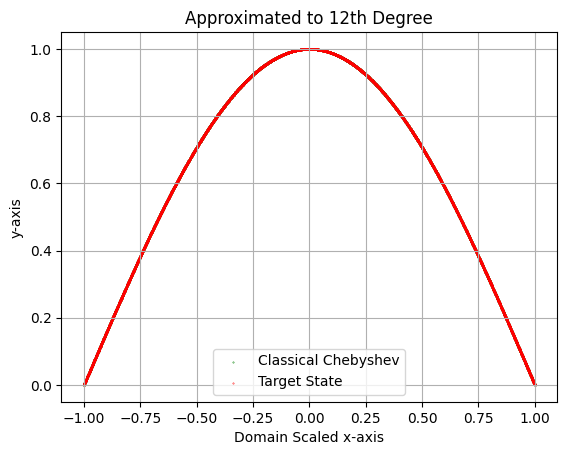

In [31]:
plt.xlabel("Domain Scaled x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

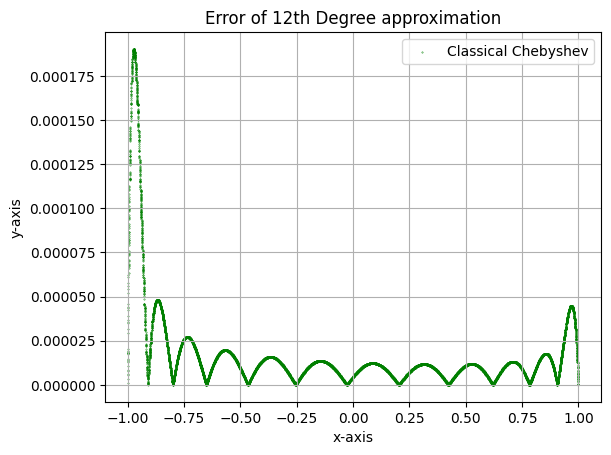

In [10]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of {d}th Degree approximation")
plt.scatter(x_array,np.abs(y_classical-y),
             color='green', label='Classical Chebyshev',s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [16]:
def get_QSVT_angles(full_coeffs):
    """
    Takes a full list of Chebyshev coefficients for a general polynomial and
    returns the two sets of QSVT angles for its even and odd parts.

    Args:
        full_coeffs (list or np.array): The d+1 Chebyshev coefficients [c0, c1, ...].

    Returns:
        tuple: A tuple containing (phases_even, phases_odd).
    """
    
    # --- 1. Process the EVEN part ---
    parity_even = 0
    # Extract the coefficients for the even terms (c0, c2, c4, ...)
    reduced_coeffs_even = np.array(full_coeffs[parity_even::2])
    
    print("--- Finding angles for EVEN part ---")
    (phases_even, _, _, _) = sym_qsp_opt.newton_solver(
        reduced_coeffs_even, 
        parity_even
    )
    print(f"Found {len(phases_even)} angles for the EVEN part.\n")

    # --- 2. Process the ODD part ---
    parity_odd = 1
    # Extract the coefficients for the odd terms (c1, c3, c5, ...)
    reduced_coeffs_odd = np.array(full_coeffs[parity_odd::2])

    print("--- Finding angles for ODD part ---")
    (phases_odd, _, _, _) = sym_qsp_opt.newton_solver(
        reduced_coeffs_odd, 
        parity_odd
    )
    print(f"Found {len(phases_odd)} angles for the ODD part.\n")
    
    return phases_even, phases_odd

In [17]:
print(f"The Chebyshev polynomial {len(chebyshev_coeffs)} coefficients to encode on Quantum Circuit are: ")
chebyshev_coeffs/=M
print(chebyshev_coeffs)

print("\n")
Phase_even, Phase_odd= get_QSVT_angles(chebyshev_coeffs)


phases = []
for i in range(len(Phase_odd)):
    phases.append(Phase_even[i])
    phases.append(Phase_odd[i])
phases.append(Phase_even[-1])


The Chebyshev polynomial 13 coefficients to encode on Quantum Circuit are: 
[ 0.15914953  0.11280999 -0.02930312  0.01015057 -0.00395521  0.00164482
 -0.00071195  0.00031698 -0.00014369  0.00006527 -0.00003001  0.0000123
 -0.00000548]


--- Finding angles for EVEN part ---
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.154e-03
iter: 002 --- err: 1.195e-07
iter: 003 --- err: 1.297e-15
[sym_qsp] Stop criteria satisfied.
Found 7 angles for the EVEN part.

--- Finding angles for ODD part ---
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 3.253e-04
iter: 002 --- err: 6.705e-09
iter: 003 --- err: 7.753e-17
[sym_qsp] Stop criteria satisfied.
Found 6 angles for the ODD part.



In [ ]:
def FindNextK(ki,ThetaL, ThetaU, upI, r=2):
    Ki= 4*ki+2 # current θ-factor
    ThetaI_min= Ki*ThetaL # lower bound for scaled θ
    ThetaI_max= Ki*ThetaU # upper bound for scaled θ

    # set an upper bound for θ-factor
    K_max= np.floor((np.pi)/(ThetaU-ThetaL))

    # largest potential candidate of the form 4k + 2
    K= K_max-np.mod(K_max-2,4)


    while K>=r*Ki:
        q= K/Ki # factor to scale [θmini , θmaxi ]
        if np.mod(q*ThetaI_max,2*np.pi)<=np.pi and np.mod(q*ThetaI_min,2*np.pi)<=np.pi :
            # [θmini+1, θmaxi+1] is in upper half-plane 
            Ki1= K
            upI1= True
            ki1= (Ki1-2)/4
            return ki1,upI1
        
        elif np.mod(q*ThetaI_max,2*np.pi)>=np.pi and np.mod(q*ThetaI_min,2*np.pi)>=np.pi :
            # [θmini+1, θmaxi+1] is in lower half-plane
            Ki1= K
            upI1= False
            ki1= (Ki1-2)/4
            return ki1, upI1
        K-=4
    return ki,upI # return old value
   

In [18]:
def loader(qc,Qbit,ancilla,phases):

    qc.h(Qbit)

    qc.barrier(Qbit)
    return qc

def loaderInverse(qc,Qbit,ancilla,phases):

    qc.h(Qbit)
    qc.barrier(Qbit)

    return qc

In [28]:
Qbit= QuantumRegister(num_qubits+1,name='logical')
Cbit= ClassicalRegister(num_qubits+1,name='result')
ancilla= QuantumRegister(3,name='anc')

qc= QuantumCircuit(Qbit,ancilla,Cbit)


# First time prepare to the state.
# This brings |0>n |0>------> |psi0>|0>+ |psi1>|1> 
# from the phases extracted from Chebyshev approximated Polynomial 
# For now it is just H gate
qc=loader(qc,Qbit,ancilla,phases)


# Spsi0 is just flipping the last Ancilla qubit Phase. As there are n qubits + 1 Ancilla qubit
#  Just XZX gate to last n+1th qubit will do the job
#  |psi0>|0>+ |psi1>|1>  ----->  -|psi0>|0> + |psi1||1>
qc.x(Qbit[num_qubits])
qc.z(Qbit[num_qubits])
qc.x(Qbit[num_qubits])
qc.barrier(Qbit)
#For now loader and loaderInverse are just H gates. 
# A^-1 oracle
qc=loaderInverse(qc,Qbit,ancilla,phases)


# S0 is basically  I-2|0 x 0| because we are kicking back |0> in kickback
# Basically an OR gate kickback. so |00...0> is kicked back. Everything else remains the same

# This flips the phase of the state where all qubits in Qbit are 0.
# Flip all qubits from |0> to |1> with X-gates
qc.x(Qbit)

# Apply a multi-controlled Z gate (mcz).
# mcp(np.pi, ...) is equivalent to mcz.
# This flips the phase of the |11...1> state.
control_qubits = Qbit[:-1]  # All qubits except the last one
target_qubit = Qbit[-1]     # The last qubit
qc.mcp(np.pi, control_qubits, target_qubit)

# 3. Flip all qubits back with X-gates
qc.x(Qbit)
qc.barrier(Qbit)
# A
qc= loader(qc,Qbit,ancilla,phases)


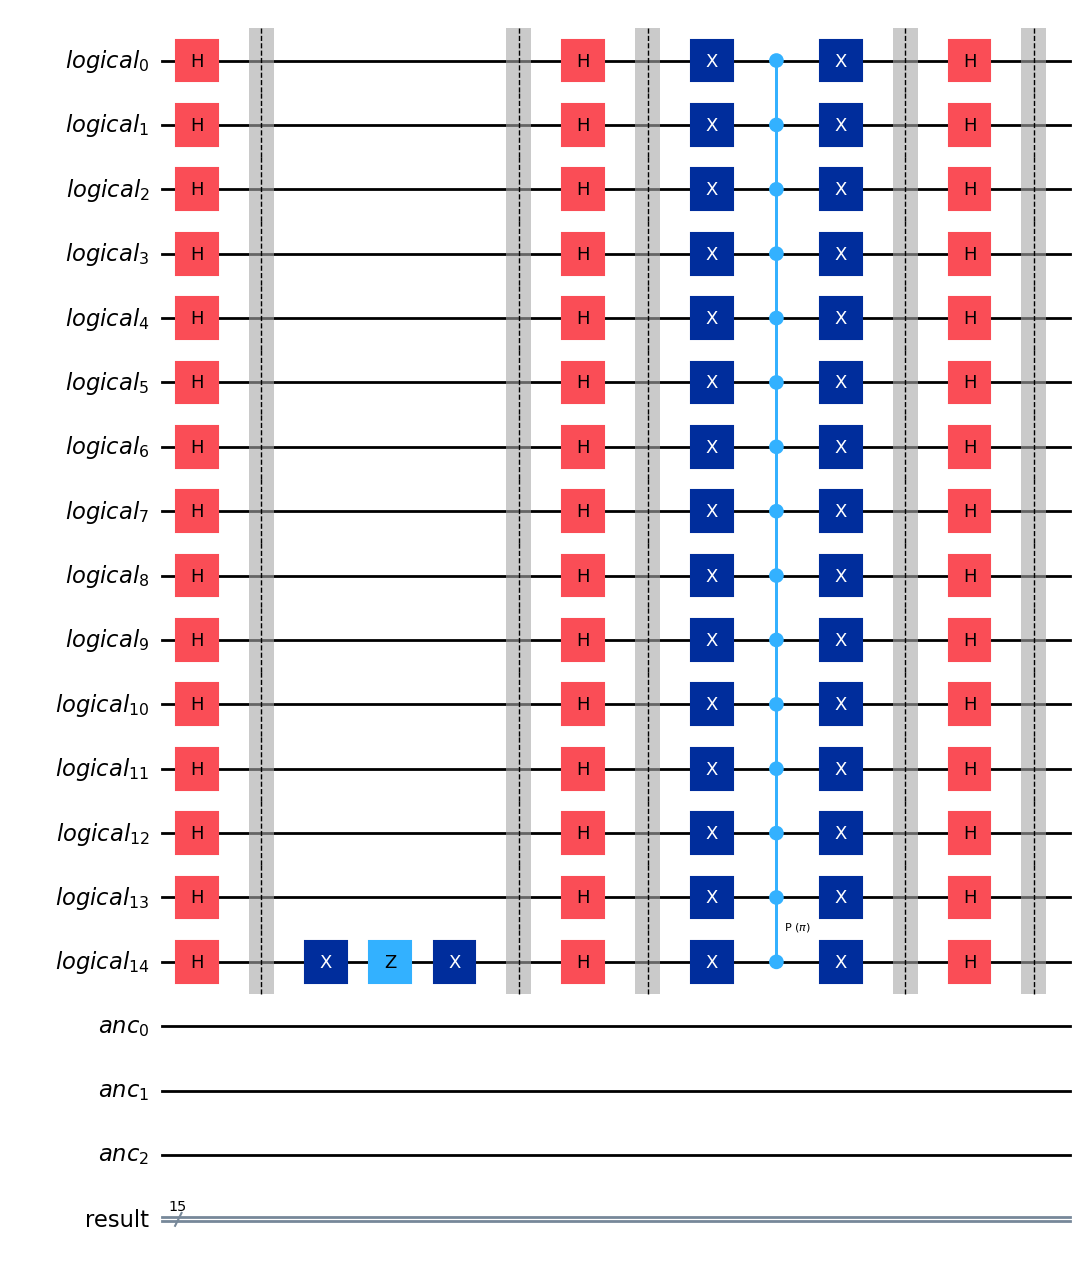

In [29]:
qc.draw('mpl')

In [ ]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)